# Mount Google Drive in Google Colab

Mount Google Drive to access files from Colab

In [ ]:
# Import the Google Drive module for Colab
from google.colab import drive

# Mount Google Drive to access files from '/content/drive'
# A prompt will appear asking for authorization
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Unzip Dataset and Explore Directory

Extract ZIP file from Drive and display folder contents

In [ ]:
import zipfile  # for working with zip files
import os       # for interacting with the file system

# Path to your ZIP file
zip_path = '/content/drive/MyDrive/melanoma_dataset.zip'
extract_dir = '/content/melanoma_dataset'  # directory to extract files

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)  # extract all contents to specified directory

print("Extraction complete!")

# Check directory structure
for root, dirs, files in os.walk(extract_dir):  # walk through directory tree
    print(root)                                 # current folder path
    print("Subdirectories:", dirs)              # list of subfolders
    print("Files:", files[:5])                  # list first 5 files in the folder
    print("-----")


Extraction complete!
/content/melanoma_dataset
Subdirectories: ['melanoma_cancer_dataset']
Files: []
-----
/content/melanoma_dataset/melanoma_cancer_dataset
Subdirectories: ['train', 'test']
Files: []
-----
/content/melanoma_dataset/melanoma_cancer_dataset/train
Subdirectories: ['malignant', 'benign']
Files: []
-----
/content/melanoma_dataset/melanoma_cancer_dataset/train/malignant
Subdirectories: []
Files: ['melanoma_8376.jpg', 'melanoma_6927.jpg', 'melanoma_5267.jpg', 'melanoma_5617.jpg', 'melanoma_6378.jpg']
-----
/content/melanoma_dataset/melanoma_cancer_dataset/train/benign
Subdirectories: []
Files: ['melanoma_3486.jpg', 'melanoma_2426.jpg', 'melanoma_1771.jpg', 'melanoma_852.jpg', 'melanoma_1903.jpg']
-----
/content/melanoma_dataset/melanoma_cancer_dataset/test
Subdirectories: ['malignant', 'benign']
Files: []
-----
/content/melanoma_dataset/melanoma_cancer_dataset/test/malignant
Subdirectories: []
Files: ['melanoma_10544.jpg', 'melanoma_10344.jpg', 'melanoma_10236.jpg', 'melanom

# Visualize Sample Images from Dataset

Load and display sample images from the melanoma dataset. This code sets the path to training images, lists a few benign and malignant image filenames, and defines a function to visualize these images side by side using matplotlib for better understanding of the dataset.

Benign sample images: ['melanoma_3486.jpg', 'melanoma_2426.jpg', 'melanoma_1771.jpg', 'melanoma_852.jpg', 'melanoma_1903.jpg']
Malignant sample images: ['melanoma_8376.jpg', 'melanoma_6927.jpg', 'melanoma_5267.jpg', 'melanoma_5617.jpg', 'melanoma_6378.jpg']


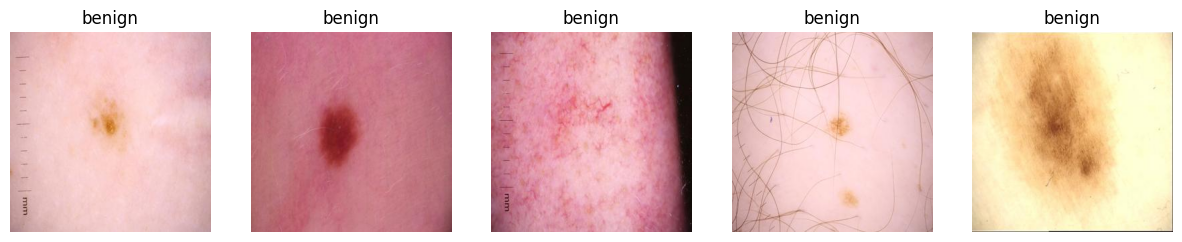

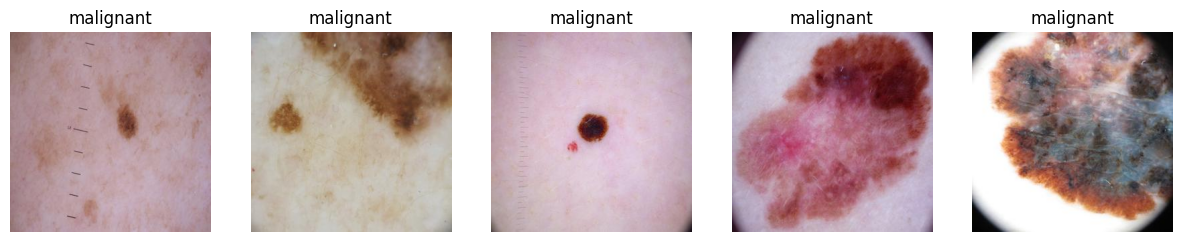

In [ ]:
import matplotlib.pyplot as plt  # for plotting images
import matplotlib.image as mpimg # for reading image files
import os                        # for file and directory operations

# Set dataset paths
train_dir = '/content/melanoma_dataset/melanoma_cancer_dataset/train'  # main training directory
benign_dir = os.path.join(train_dir, 'benign')        # path to benign images
malignant_dir = os.path.join(train_dir, 'malignant')  # path to malignant images

# List some images from each category
print("Benign sample images:", os.listdir(benign_dir)[:5])       # show first 5 benign images
print("Malignant sample images:", os.listdir(malignant_dir)[:5]) # show first 5 malignant images

# Function to visualize images
def plot_images(image_paths, title, num_images=5):
    plt.figure(figsize=(15, 5))  # set the overall figure size
    for i, img_name in enumerate(image_paths[:num_images]):
        img_path = os.path.join(title, img_name)   # get the full image path
        img = mpimg.imread(img_path)               # read image data
        plt.subplot(1, num_images, i + 1)          # plot images in a single row
        plt.imshow(img)                            # display the image
        plt.axis('off')                            # hide axes for cleaner look
        plt.title(title.split('/')[-1])            # show 'benign' or 'malignant' as title
    plt.show()                                     # display all plotted images

# Show 5 sample benign and 5 sample malignant images for quick data inspection
plot_images(os.listdir(benign_dir), benign_dir)
plot_images(os.listdir(malignant_dir), malignant_dir)


# Prepare Data Generators with Augmentation

Set up data generators for training and validation. Use data augmentation techniques like rotation, zoom, and flip to improve model generalization. The dataset is split into training and validation sets using Keras' ImageDataGenerator.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # for real-time data augmentation

# Image size for the model
IMG_SIZE = (224, 224)  # standard input size for many CNN models like ResNet, EfficientNet
BATCH_SIZE = 32        # number of images per batch

# Data augmentation for training, only rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1./255,            # normalize pixel values to [0, 1]
    rotation_range=20,         # randomly rotate images by up to 20 degrees
    zoom_range=0.2,            # randomly zoom images by 20%
    horizontal_flip=True,      # randomly flip images horizontally
    validation_split=0.2       # split 20% of data for validation
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,                 # directory with 'benign' and 'malignant' folders
    target_size=IMG_SIZE,      # resize images to 224x224
    batch_size=BATCH_SIZE,     # batch size
    class_mode='binary',       # binary labels (benign=0, malignant=1)
    subset='training',         # this is the training data
    shuffle=True               # shuffle the data for randomness
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,                 # same directory as training
    target_size=IMG_SIZE,      # resize images to 224x224
    batch_size=BATCH_SIZE,     # batch size
    class_mode='binary',       # binary labels
    subset='validation',       # this is the validation data
    shuffle=True               # shuffle for better evaluation
)

# Optional: Check class indices to confirm mapping
print("Class Indices:", train_generator.class_indices)  # e.g., {'benign': 0, 'malignant': 1}


Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.
Class Indices: {'benign': 0, 'malignant': 1}


# Build and Train EfficientNetB0 Model

Load a pre-trained EfficientNetB0 model without its top layers. Freeze the base for transfer learning, add custom layers for binary classification, compile, and train the model using augmented melanoma data.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0  # import pre-trained model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout  # custom layers
from tensorflow.keras.models import Model  # for creating the full model
from tensorflow.keras.optimizers import Adam  # optimizer

# Load pre-trained EfficientNetB0 without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model to keep pre-trained weights unchanged during initial training
base_model.trainable = False

# Add custom top layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)     # reduces feature map to a single 1D vector
x = Dropout(0.5)(x)                 # dropout for regularization (prevent overfitting)
predictions = Dense(1, activation='sigmoid')(x)  # final layer for binary output

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),  # Adam optimizer with learning rate
              loss='binary_crossentropy',           # suitable loss for binary classification
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])  # track accuracy and AUC

# Train the model
history = model.fit(
    train_generator,       # training data with augmentation
    epochs=30,             # number of training epochs
    validation_data=val_generator  # validation data
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 163s 582ms/step - accuracy: 0.5036 - auc: 0.5004 - loss: 0.7071 - val_accuracy: 0.5206 - val_auc: 0.5000 - val_loss: 0.6953
Epoch 2/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 119s 495ms/step - accuracy: 0.5105 - auc: 0.5119 - loss: 0.7006 - val_accuracy: 0.5206 - val_auc: 0.5037 - val_loss: 0.6923
Epoch 3/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 136s 565ms/step - accuracy: 0.4952 - auc: 0.4867 - loss: 0.7041 - val_accuracy: 0.8116 - val_auc: 0.5017 - val_loss: 0.6924
Epoch 4/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 120s 499ms/step - accuracy: 0.5074 - auc: 0.5021 - loss: 0.6994 - val_accuracy: 0.5206 - val_auc: 0.5000 - val_loss: 0.6916
Epoch 5/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 120s 498ms/step - accuracy: 0.5045 - auc: 0.4990 - loss: 0.6997 - val_accuracy: 0.5206 - val_auc: 0.5111 - val_loss: 0.7012
Epoch 6/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 119s 493ms/step - accuracy: 0.5143 - auc: 0.4987 - loss: 0.7017 - val_accuracy: 0.5206 - val_auc: 0.7517 - val_loss: 0.6913
Epoch 7/30
241/2

# Visualize Model Predictions with Grad-CAM

Generate Grad-CAM heatmaps to visualize which parts of the image the model focuses on for predictions. This helps understand model interpretability by



    highlighting regions important for classifying melanoma.

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


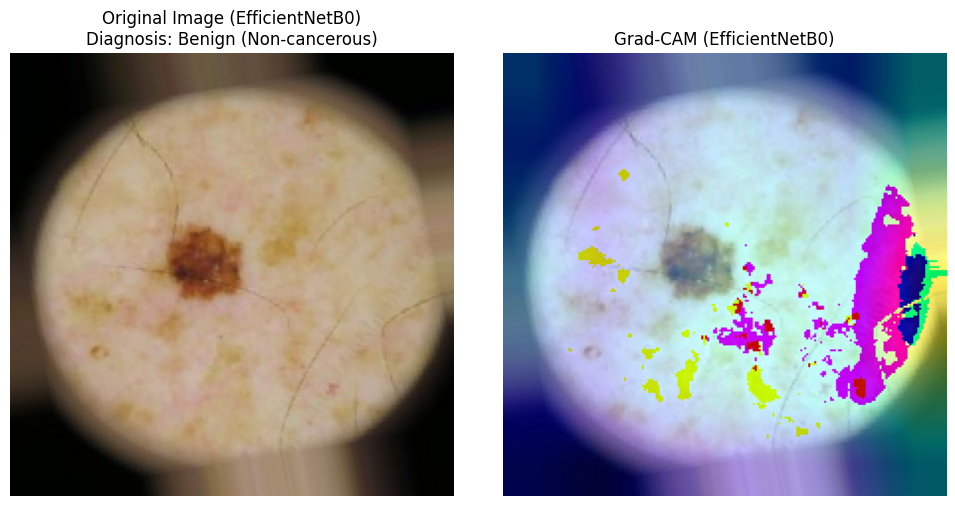

Predicted Probability of Malignant: 0.4439
Predicted Diagnosis: Benign (Non-cancerous)


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing

# Grad-CAM function remains the same
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        model.input, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to overlay heatmap remains the same
def superimpose_heatmap(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + np.uint8(img * 255)
    return superimposed_img

# Pick one validation image
img, label = next(val_generator)
sample_img = img[0]
sample_img_array = np.expand_dims(sample_img, axis=0)

# Predict the class
pred_prob = model.predict(sample_img_array)[0][0]
pred_label = int(pred_prob > 0.5)

# Map prediction to diagnosis
diagnosis = "Benign (Non-cancerous)" if pred_label == 0 else "Malignant (Melanoma)"

# Grad-CAM for EfficientNetB0 last conv layer
last_conv_layer_name = 'top_conv'

# Generate heatmap
heatmap = make_gradcam_heatmap(sample_img_array, model, last_conv_layer_name)

# Superimpose heatmap
superimposed_img = superimpose_heatmap(sample_img, heatmap)

# Plot original and Grad-CAM images with prediction
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title(f"Original Image (EfficientNetB0)\nDiagnosis: {diagnosis}", fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img.astype('uint8'))
plt.title("Grad-CAM (EfficientNetB0)", fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.show()

# Print additional prediction details
print(f"Predicted Probability of Malignant: {pred_prob:.4f}")
print(f"Predicted Diagnosis: {diagnosis}")


# Fine-Tune the Pre-trained Model

Unfreeze the base EfficientNetB0 layers for fine-tuning. Re-compile the model with a lower learning rate to carefully update all layers, and train for more epochs to improve performance.

In [ ]:
# Unfreeze the base model
base_model.trainable = True  # allow weights in the base model to be updated

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # smaller LR to avoid large updates
              loss='binary_crossentropy',                              # binary classification loss
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])  # monitor accuracy and AUC

# Fine-tune for 20 more epochs
fine_tune_epochs = 20

# Continue training with unfrozen base model
history_fine = model.fit(
    train_generator,           # training data
    epochs=fine_tune_epochs,   # number of fine-tuning epochs
    validation_data=val_generator  # validation data
)


Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 249s 715ms/step - accuracy: 0.6700 - auc: 0.7724 - loss: 0.6011 - val_accuracy: 0.4274 - val_auc: 0.2380 - val_loss: 0.7181
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 126s 522ms/step - accuracy: 0.8491 - auc: 0.9252 - loss: 0.3727 - val_accuracy: 0.6726 - val_auc: 0.7178 - val_loss: 0.6215
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 143s 528ms/step - accuracy: 0.8681 - auc: 0.9368 - loss: 0.3233 - val_accuracy: 0.5851 - val_auc: 0.7427 - val_loss: 0.7018
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 128s 530ms/step - accuracy: 0.8846 - auc: 0.9542 - loss: 0.2766 - val_accuracy: 0.3639 - val_auc: 0.3446 - val_loss: 1.4063
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 125s 520ms/step - accuracy: 0.8883 - auc: 0.9579 - loss: 0.2620 - val_accuracy: 0.6054 - val_auc: 0.7663 - val_loss: 0.6625
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 126s 521ms/step - accuracy: 0.8976 - auc: 0.9601 - loss: 0.2534 - val_accuracy: 0.5685 - val_auc: 0.6902 - val_loss: 0.7386
Epoch 7/20
241/2

# Evaluate Model on Test Data

Load test images, preprocess with rescaling, and evaluate the fine-tuned model on unseen data to check its performance in terms of accuracy and AUC.

In [ ]:
# Set test directory
test_dir = '/content/melanoma_dataset/melanoma_cancer_dataset/test'

# Create test data generator (no augmentation, just rescale pixel values)
test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,                   # directory containing test images
    target_size=IMG_SIZE,       # resize to match model input
    batch_size=BATCH_SIZE,      # batch size
    class_mode='binary',        # binary labels for evaluation
    shuffle=False               # do not shuffle to maintain order for predictions
)

# Evaluate model on test data
test_loss, test_accuracy, test_auc = model.evaluate(test_generator)  # get loss, accuracy, AUC

# Print evaluation results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Found 1000 images belonging to 2 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.9352 - auc: 0.5128 - loss: 0.1776
Test Accuracy: 0.8510
Test AUC: 0.9573


# Generate Confusion Matrix and Classification Report

Predict on the test set and evaluate detailed model performance using a confusion matrix and classification report, showing precision, recall, and F1-score for benign and malignant classes.

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 275ms/step
Confusion Matrix:
 [[495   5]
 [144 356]]


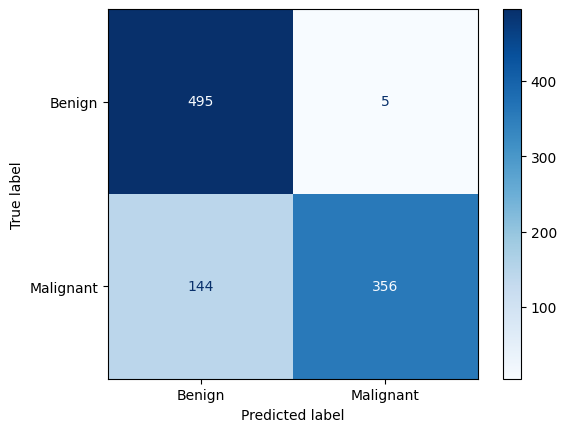

Classification Report:
               precision    recall  f1-score   support

      Benign       0.77      0.99      0.87       500
   Malignant       0.99      0.71      0.83       500

    accuracy                           0.85      1000
   macro avg       0.88      0.85      0.85      1000
weighted avg       0.88      0.85      0.85      1000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

# Predict on test set
test_generator.reset()  # reset generator to start from first batch
pred_probs = model.predict(test_generator)  # get predicted probabilities
pred_labels = (pred_probs > 0.5).astype(int).flatten()  # convert to binary labels

# True labels from test generator
true_labels = test_generator.classes  # ground truth labels

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)  # compute confusion matrix
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)  # display in blue color map
plt.show()

# Classification report
report = classification_report(true_labels, pred_labels, target_names=['Benign', 'Malignant'])
print("Classification Report:\n", report)


# Plot Training and Validation Performance

Visualize training and validation accuracy and loss over epochs for both initial training and fine-tuning phases. This helps assess model learning behavior and overfitting.

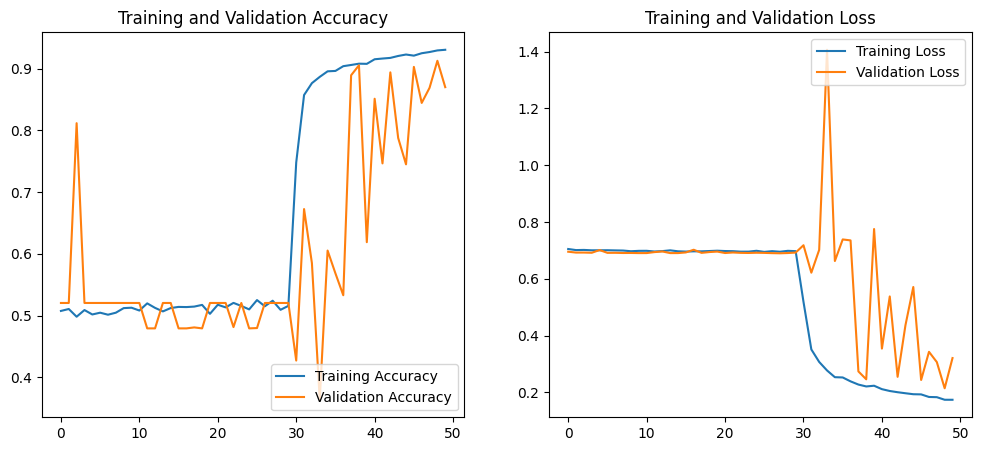

In [ ]:
import matplotlib.pyplot as plt  # for plotting graphs

# Combine both histories if you did fine-tuning
def plot_history(history1, history2=None):
    acc = history1.history['accuracy']           # training accuracy from first phase
    val_acc = history1.history['val_accuracy']   # validation accuracy from first phase
    loss = history1.history['loss']              # training loss from first phase
    val_loss = history1.history['val_loss']      # validation loss from first phase

    if history2:
        acc += history2.history['accuracy']      # append fine-tuning accuracy
        val_acc += history2.history['val_accuracy']
        loss += history2.history['loss']
        val_loss += history2.history['val_loss']

    epochs_range = range(len(acc))  # total number of epochs

    plt.figure(figsize=(12, 5))  # set figure size

    # Accuracy plot
    plt.subplot(1, 2, 1)  # first subplot for accuracy
    plt.plot(epochs_range, acc, label='Training Accuracy')       # plot training accuracy
    plt.plot(epochs_range, val_acc, label='Validation Accuracy') # plot validation accuracy
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)  # second subplot for loss
    plt.plot(epochs_range, loss, label='Training Loss')         # plot training loss
    plt.plot(epochs_range, val_loss, label='Validation Loss')   # plot validation loss
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Plot the graphs
plot_history(history, history_fine)


# Train ResNet50 Model for Melanoma Classification

Load a pre-trained ResNet50 model without top layers, freeze the base for transfer learning, add custom layers for binary classification, compile, and train it on the melanoma dataset.

In [ ]:
from tensorflow.keras.applications import ResNet50  # import ResNet50 pre-trained model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout  # custom layers
from tensorflow.keras.models import Model  # for creating the final model

# Load ResNet50 base model without top layers
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet.trainable = False  # freeze base model for initial training

# Custom top layers for binary classification
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)      # global average pooling to reduce dimensions
x = Dropout(0.5)(x)                  # dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # output layer for binary classification

# Final ResNet50 model
resnet_model = Model(inputs=base_model_resnet.input, outputs=predictions)

# Compile the model
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer
                     loss='binary_crossentropy',                               # loss for binary classification
                     metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])   # accuracy and AUC metrics

# Train ResNet50 model (try 30 epochs for testing)
history_resnet = resnet_model.fit(
    train_generator,    # training data generator
    epochs=30,          # number of epochs
    validation_data=val_generator  # validation data generator
)


Epoch 1/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 146s 560ms/step - accuracy: 0.5045 - auc: 0.5115 - loss: 0.7434 - val_accuracy: 0.6117 - val_auc: 0.8360 - val_loss: 0.6786
Epoch 2/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 141s 586ms/step - accuracy: 0.5536 - auc: 0.5712 - loss: 0.6840 - val_accuracy: 0.6075 - val_auc: 0.8583 - val_loss: 0.6672
Epoch 3/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 125s 517ms/step - accuracy: 0.5750 - auc: 0.6106 - loss: 0.6721 - val_accuracy: 0.6939 - val_auc: 0.8567 - val_loss: 0.6594
Epoch 4/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 158s 583ms/step - accuracy: 0.6044 - auc: 0.6369 - loss: 0.6623 - val_accuracy: 0.7486 - val_auc: 0.8638 - val_loss: 0.6525
Epoch 5/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 142s 589ms/step - accuracy: 0.6034 - auc: 0.6382 - loss: 0.6594 - val_accuracy: 0.6236 - val_auc: 0.8621 - val_loss: 0.6485
Epoch 6/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 124s 515ms/step - accuracy: 0.6179 - auc: 0.6646 - loss: 0.6493 - val_accuracy: 0.6882 - val_auc: 0.8743 - val_loss: 0.6382
Epoch 7/30
241/2

# Enhanced Data Augmentation for Training

Apply stronger data augmentation techniques to increase dataset diversity and reduce overfitting. Includes rotation, zoom, shear, brightness adjustment, and both horizontal and vertical flipping.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,              # normalize pixel values to [0, 1]
    rotation_range=30,           # randomly rotate images by up to 30 degrees
    zoom_range=0.3,              # randomly zoom images up to 30%
    shear_range=0.2,             # apply shearing transformations
    brightness_range=[0.8, 1.2], # randomly adjust brightness between 80% and 120%
    horizontal_flip=True,        # randomly flip images horizontally
    vertical_flip=True,          # randomly flip images vertically
    validation_split=0.2         # 20% of training data used for validation
)


# Ensemble Predictions from ResNet50 and EfficientNetB0

Predict on the test set using both ResNet50 and EfficientNetB0 models, average their predictions to form an ensemble, and evaluate the combined model’s performance with a confusion matrix.

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


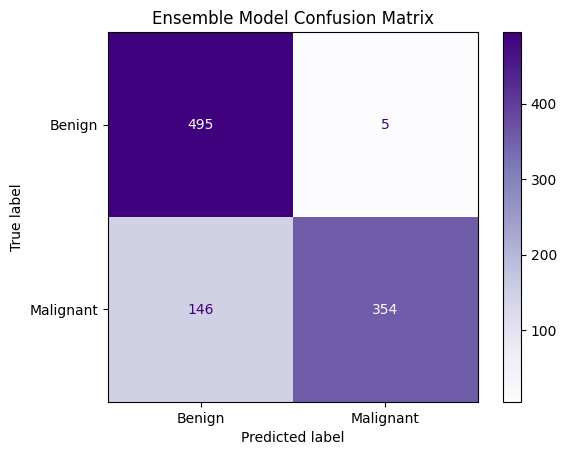

In [ ]:
# Predict on test set with both models
resnet_preds = resnet_model.predict(test_generator)       # predictions from ResNet50
efficientnet_preds = model.predict(test_generator)        # predictions from EfficientNetB0

# Average predictions for ensemble
ensemble_preds = (resnet_preds + efficientnet_preds) / 2  # simple average of probabilities
ensemble_labels = (ensemble_preds > 0.5).astype(int).flatten()  # convert to binary labels

# Confusion Matrix for Ensemble Model
cm_ensemble = confusion_matrix(true_labels, ensemble_labels)  # compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Purples)  # use purple colormap for visual
plt.title("Ensemble Model Confusion Matrix")
plt.show()


# Setup Data Generators for Training, Validation, and Testing

Define data generators for training, validation, and test datasets. Apply strong data augmentation on training data to improve model robustness and use rescaling for all sets to normalize pixel values.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to dataset directories
train_dir = '/content/melanoma_dataset/melanoma_cancer_dataset/train'
test_dir = '/content/melanoma_dataset/melanoma_cancer_dataset/test'

# Image settings
IMG_SIZE = (224, 224)   # standard input size for CNNs
BATCH_SIZE = 32         # batch size for training

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,                # normalize pixel values to [0, 1]
    rotation_range=30,             # random rotations up to 30 degrees
    zoom_range=0.3,                # random zoom up to 30%
    shear_range=0.2,               # random shear transformations
    brightness_range=[0.8, 1.2],   # random brightness adjustment
    horizontal_flip=True,          # random horizontal flips
    vertical_flip=True,            # random vertical flips
    validation_split=0.2           # split 20% for validation
)

# Train Generator (with augmentation)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,       # resize images to 224x224
    batch_size=BATCH_SIZE,      # batch size for training
    class_mode='binary',        # binary classification
    subset='training'           # training data subset
)

# Validation Generator (same augmentation but subset of data)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,       # resize images to 224x224
    batch_size=BATCH_SIZE,      # batch size for validation
    class_mode='binary',        # binary classification
    subset='validation'         # validation data subset
)

# Test Generator (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,       # resize test images
    batch_size=BATCH_SIZE,      # batch size for testing
    class_mode='binary',        # binary classification
    shuffle=False               # keep order for predictions
)


Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Train EfficientNetB0 Model for Melanoma Detection

Load a pre-trained EfficientNetB0 model, freeze its base for transfer learning, add custom layers for binary classification, compile with Adam optimizer, and train it on the melanoma dataset.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0  # import EfficientNetB0 model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout  # custom layers
from tensorflow.keras.models import Model  # to build the final model
from tensorflow.keras.optimizers import Adam  # optimizer for training

# Load base EfficientNetB0 model without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base model for initial training

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # reduce feature maps to 1D vector
x = Dropout(0.5)(x)              # dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # binary output layer

# Build the full model
efficientnet_model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
efficientnet_model.compile(optimizer=Adam(learning_rate=0.001),  # learning rate for initial training
                           loss='binary_crossentropy',            # loss for binary classification
                           metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])  # track accuracy and AUC

# Train the model for 30 epochs
history_eff = efficientnet_model.fit(
    train_generator,       # training data generator
    epochs=30,             # number of epochs
    validation_data=val_generator  # validation data generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 181s 652ms/step - accuracy: 0.5110 - auc: 0.5066 - loss: 0.7055 - val_accuracy: 0.5206 - val_auc: 0.6369 - val_loss: 0.6924
Epoch 2/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 138s 571ms/step - accuracy: 0.4980 - auc: 0.4943 - loss: 0.7029 - val_accuracy: 0.4794 - val_auc: 0.7624 - val_loss: 0.7036
Epoch 3/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 153s 635ms/step - accuracy: 0.5113 - auc: 0.5092 - loss: 0.7008 - val_accuracy: 0.5206 - val_auc: 0.7059 - val_loss: 0.6917
Epoch 4/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 151s 628ms/step - accuracy: 0.5129 - auc: 0.5029 - loss: 0.6979 - val_accuracy: 0.5206 - val_auc: 0.6864 - val_loss: 0.6913
Epoch 5/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 138s 573ms/step - accuracy: 0.4946 - auc: 0.4948 - loss: 0.7000 - val_accuracy: 0.5206 - val_auc: 0.6380 - val_loss: 0.6918
Epoch 6/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 137s 569ms/step - accuracy: 0.5024 - auc: 0.5004 - loss: 0.7004 - val_accuracy: 0.4794 - val_auc: 0.5600 - val_loss: 0.6943
Epoch 7/30
241/2

# Train ResNet50 Model for Melanoma Classification

Load a pre-trained ResNet50 model, freeze its convolutional base, add custom layers for binary classification, compile the model using the Adam optimizer, and train it on the melanoma dataset for 30 epochs.

In [ ]:
from tensorflow.keras.applications import ResNet50  # import ResNet50 model

# Load ResNet50 base model without top layers
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_resnet.trainable = False  # freeze base model layers for transfer learning

# Add custom classification layers
x = base_resnet.output
x = GlobalAveragePooling2D()(x)  # convert feature maps to a 1D vector
x = Dropout(0.5)(x)              # add dropout for regularization
output = Dense(1, activation='sigmoid')(x)  # final layer for binary classification

# Build the full ResNet model
resnet_model = Model(inputs=base_resnet.input, outputs=output)

# Compile the model with Adam optimizer
resnet_model.compile(optimizer=Adam(learning_rate=0.001),   # learning rate for initial training
                     loss='binary_crossentropy',            # binary classification loss
                     metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])  # track accuracy and AUC

# Train the model for 30 epochs
history_resnet = resnet_model.fit(
    train_generator,       # training data generator
    epochs=30,             # number of training epochs
    validation_data=val_generator  # validation data generator
)


Epoch 1/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 166s 640ms/step - accuracy: 0.5095 - auc: 0.5110 - loss: 0.7572 - val_accuracy: 0.5310 - val_auc: 0.8436 - val_loss: 0.6807
Epoch 2/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 145s 602ms/step - accuracy: 0.5511 - auc: 0.5703 - loss: 0.6837 - val_accuracy: 0.4836 - val_auc: 0.8444 - val_loss: 0.6723
Epoch 3/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 145s 602ms/step - accuracy: 0.5757 - auc: 0.5972 - loss: 0.6744 - val_accuracy: 0.5570 - val_auc: 0.8584 - val_loss: 0.6660
Epoch 4/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 156s 648ms/step - accuracy: 0.5851 - auc: 0.6232 - loss: 0.6644 - val_accuracy: 0.5924 - val_auc: 0.8577 - val_loss: 0.6531
Epoch 5/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 191s 602ms/step - accuracy: 0.6128 - auc: 0.6345 - loss: 0.6584 - val_accuracy: 0.7147 - val_auc: 0.8595 - val_loss: 0.6513
Epoch 6/30
241/241 ━━━━━━━━━━━━━━━━━━━━ 145s 602ms/step - accuracy: 0.6132 - auc: 0.6666 - loss: 0.6486 - val_accuracy: 0.5955 - val_auc: 0.8642 - val_loss: 0.6465
Epoch 7/30
241/2

# Evaluate ResNet50 Model and Analyze Test Performance

Evaluate the trained ResNet50 model on the test set, generate predictions, and analyze the performance using a confusion matrix and a detailed classification report including precision, recall, and F1-score.

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.8626 - auc: 0.4618 - loss: 0.5403
ResNet Test Accuracy: 0.7540, Test AUC: 0.8631
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step


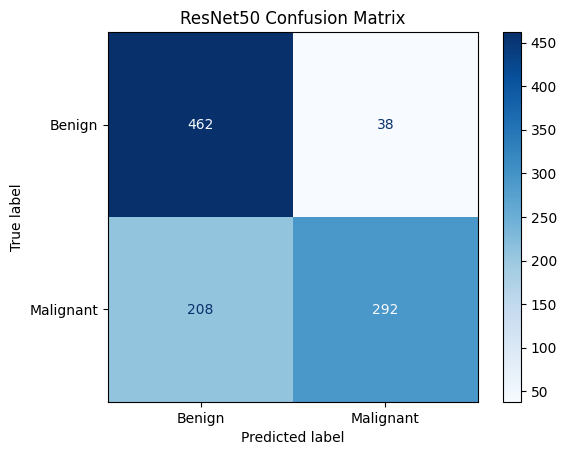

              precision    recall  f1-score   support

      Benign       0.69      0.92      0.79       500
   Malignant       0.88      0.58      0.70       500

    accuracy                           0.75      1000
   macro avg       0.79      0.75      0.75      1000
weighted avg       0.79      0.75      0.75      1000



In [ ]:
# Evaluate ResNet model on test set
resnet_eval = resnet_model.evaluate(test_generator)  # returns [loss, accuracy, AUC]
print(f"ResNet Test Accuracy: {resnet_eval[1]:.4f}, Test AUC: {resnet_eval[2]:.4f}")

# Predict on test set
pred_probs = resnet_model.predict(test_generator)                # get predicted probabilities
pred_labels = (pred_probs > 0.5).astype(int).flatten()           # convert to binary predictions
true_labels = test_generator.classes                             # true labels from test data

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(true_labels, pred_labels)                  # compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues')                                          # plot confusion matrix
plt.title("ResNet50 Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(true_labels, pred_labels, target_names=['Benign', 'Malignant']))  # precision, recall, f1


# Plot Training History with Markers for EfficientNet and ResNet50

Visualize training and validation accuracy and loss with lines and markers for both EfficientNetB0 and ResNet50 models. This allows easy comparison of learning trends, convergence, and potential overfitting.

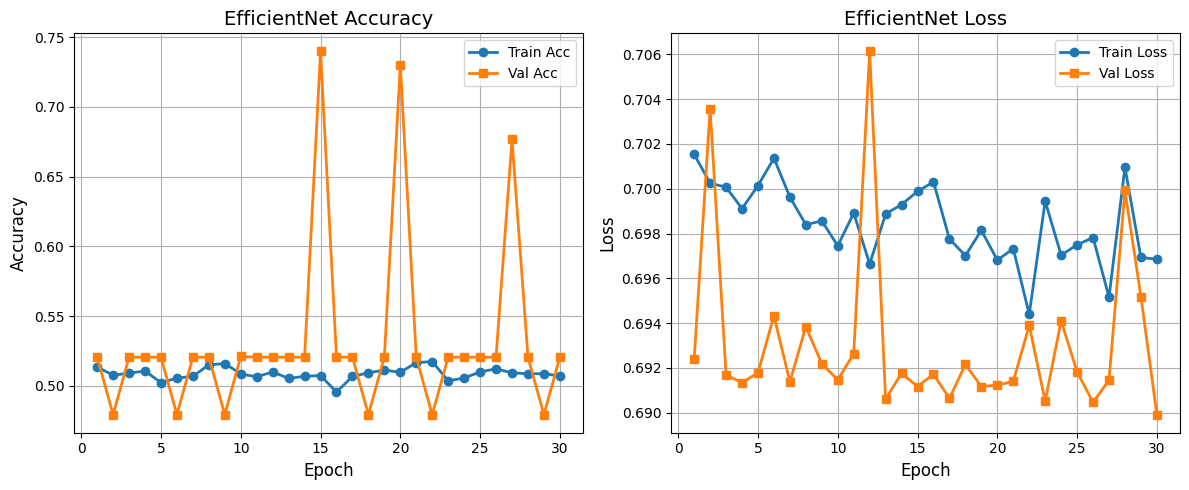

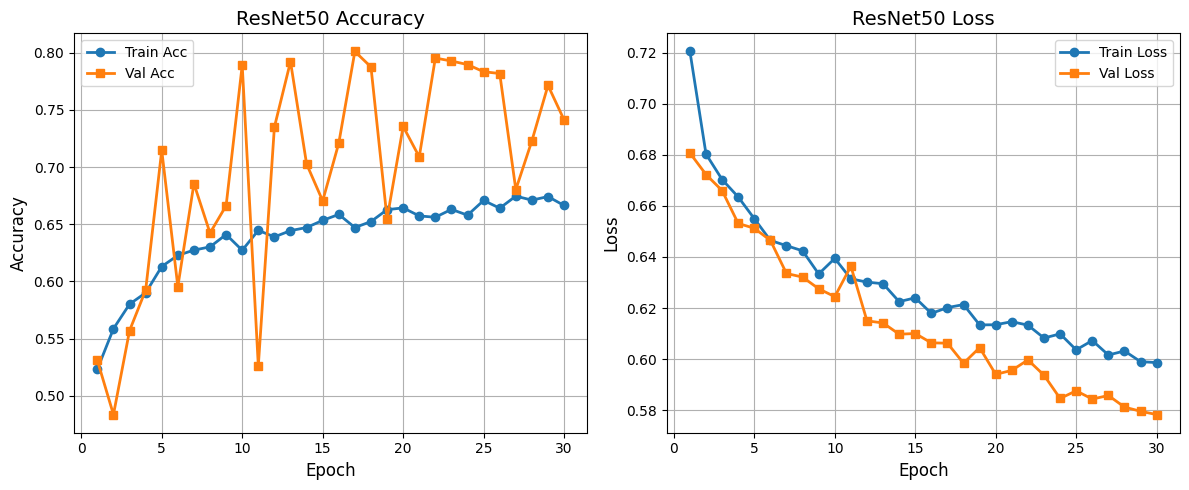

In [ ]:
# Corrected Plot History with lines + markers
def plot_history(history, title):
    acc = history.history['accuracy']               # training accuracy
    val_acc = history.history['val_accuracy']       # validation accuracy
    loss = history.history['loss']                  # training loss
    val_loss = history.history['val_loss']          # validation loss
    epochs = range(1, len(acc) + 1)                  # list of epoch numbers

    plt.figure(figsize=(12, 5))  # set figure size for side-by-side plots

    # Accuracy plot
    plt.subplot(1, 2, 1)  # first subplot for accuracy
    plt.plot(epochs, acc, '-o', label='Train Acc', linewidth=2)    # training accuracy with markers
    plt.plot(epochs, val_acc, '-s', label='Val Acc', linewidth=2)  # validation accuracy with markers
    plt.title(f'{title} Accuracy', fontsize=14)  # title with model name
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(True)  # show grid
    plt.legend()    # show legend

    # Loss plot
    plt.subplot(1, 2, 2)  # second subplot for loss
    plt.plot(epochs, loss, '-o', label='Train Loss', linewidth=2)     # training loss with markers
    plt.plot(epochs, val_loss, '-s', label='Val Loss', linewidth=2)   # validation loss with markers
    plt.title(f'{title} Loss', fontsize=14)  # title with model name
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()  # adjust subplots to fit into figure area
    plt.show()

# Re-plot training history with corrected line styles for both models
plot_history(history_eff, "EfficientNet")
plot_history(history_resnet, "ResNet50")


# Visualize ResNet50 Model Focus using Grad-CAM

 Generate and superimpose Grad-CAM heatmaps to visualize which parts of an input image influenced the model's decision. Useful for understanding how the ResNet50 model interprets melanoma features.

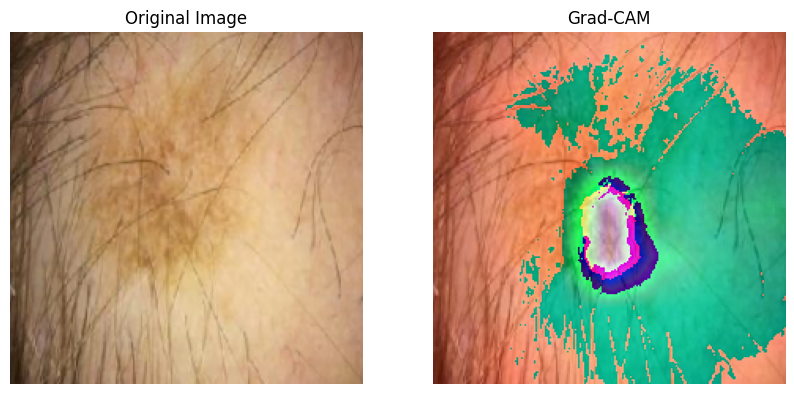

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for image manipulation

# Grad-CAM function to generate heatmaps
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        model.input, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)  # forward pass
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # use predicted class if not specified
        class_channel = predictions[:, pred_index]  # focus on class output

    grads = tape.gradient(class_channel, conv_outputs)  # compute gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # average gradients

    conv_outputs = conv_outputs[0]  # extract the conv layer output
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]  # compute weighted activation
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # normalize heatmap
    return heatmap.numpy()

# Function to overlay heatmap on the original image
def superimpose_heatmap(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # resize to match original
    heatmap = np.uint8(255 * heatmap)  # scale heatmap to 0-255
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # apply color map
    superimposed_img = heatmap_color * alpha + np.uint8(img * 255)  # overlay on original image
    return superimposed_img

# Get a sample image from validation set
img, label = next(val_generator)     # fetch a batch of validation data
sample_img = img[0]                  # select the first image from batch
sample_img_array = np.expand_dims(sample_img, axis=0)  # expand dims for batch processing

# Choose the last conv layer based on model used
# For ResNet50 use 'conv5_block3_out'
# For EfficientNetB0 use 'top_conv'
last_conv_layer_name = 'conv5_block3_out'  # change to 'top_conv' if visualizing EfficientNet

# Generate Grad-CAM heatmap for the sample image
heatmap = make_gradcam_heatmap(sample_img_array, resnet_model, last_conv_layer_name)

# Superimpose the heatmap onto the original image
superimposed_img = superimpose_heatmap(sample_img, heatmap)

# Plot the original image and Grad-CAM overlay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img.astype('uint8'))
plt.title("Grad-CAM")
plt.axis('off')

plt.show()

# Bar Chart of Models and Techniques Used

Visual representation of all models and techniques applied during the melanoma classification project

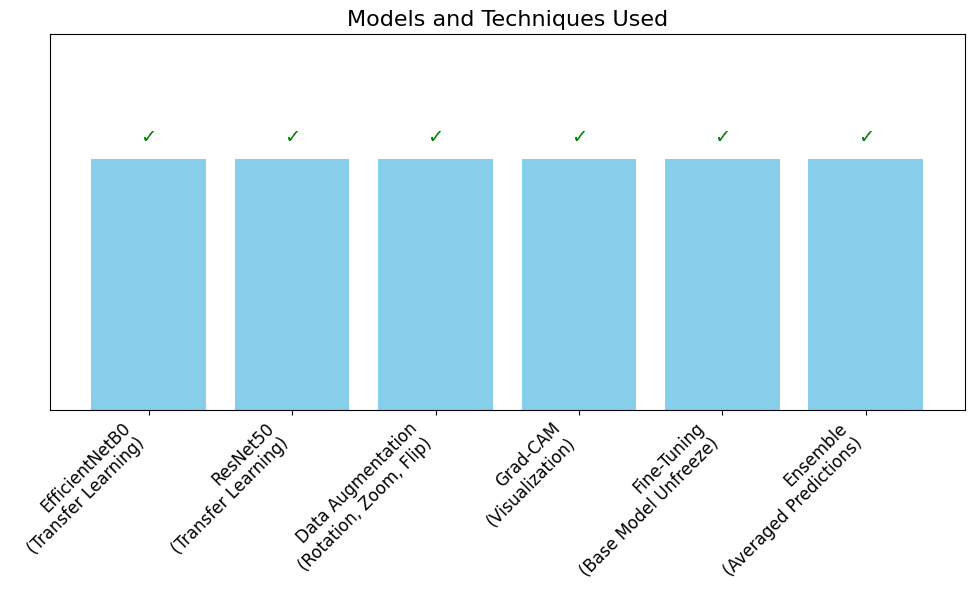

In [ ]:
import matplotlib.pyplot as plt  # for creating the bar chart

# List of models and techniques used
techniques = [
    'EfficientNetB0\n(Transfer Learning)',        # pre-trained EfficientNetB0 model
    'ResNet50\n(Transfer Learning)',              # pre-trained ResNet50 model
    'Data Augmentation\n(Rotation, Zoom, Flip)',  # image augmentation techniques
    'Grad-CAM\n(Visualization)',                  # visualization to interpret model focus
    'Fine-Tuning\n(Base Model Unfreeze)',         # fine-tuning by unfreezing base model layers
    'Ensemble\n(Averaged Predictions)'            # combining predictions from multiple models
]

# Assign dummy values to create uniform bar heights (just for visual)
values = [1, 1, 1, 1, 1, 1]

# Create the bar chart
plt.figure(figsize=(10, 6))  # set figure size
bars = plt.bar(techniques, values, color='skyblue')  # create bars with light blue color

# Add checkmark labels above each bar for visual confirmation
for bar in bars:
    height = bar.get_height()  # get the height of each bar
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.05, '✓',  # add a checkmark
             ha='center', va='bottom', fontsize=14, color='green')  # center-align, green color

# Formatting the plot
plt.ylim(0, 1.5)  # set y-axis limits to give space for checkmarks
plt.title('Models and Techniques Used', fontsize=16)  # title of the chart
plt.xticks(rotation=45, ha='right', fontsize=12)  # rotate x-axis labels for readability
plt.yticks([])  # hide y-axis tick marks and values
plt.grid(False)  # no background grid lines
plt.tight_layout()  # adjust layout for neatness
plt.show()  # display the chart


# Save Trained Models

Save the trained EfficientNetB0 and ResNet50 models for future use, including weights, architecture, and optimizer state.

In [ ]:
# Save EfficientNetB0 model
efficientnet_model.save('/content/efficientnet_melanoma_model.h5')
print("EfficientNetB0 model saved as 'efficientnet_melanoma_model.h5'")

# Save ResNet50 model
resnet_model.save('/content/resnet50_melanoma_model.h5')
print("ResNet50 model saved as 'resnet50_melanoma_model.h5'")


EfficientNetB0 model saved as 'efficientnet_melanoma_model.h5'
ResNet50 model saved as 'resnet50_melanoma_model.h5'


To load the saved models later:

In [ ]:
from tensorflow.keras.models import load_model

# Load EfficientNetB0 model
efficientnet_loaded = load_model('/content/efficientnet_melanoma_model.h5')

# Load ResNet50 model
resnet_loaded = load_model('/content/resnet50_melanoma_model.h5')
